In [1]:
import numpy as np
import pandas as pd
import mygene
import omnipath as op
import seaborn as sns
import matplotlib.pyplot as plt
import gzip

/users/pravicha/.conda/envs/vs_stitcher/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_hits(target, db):                                                                      #Function for identifying genes that are targets or receptors (tgts) within a given database (db)
    hits = db['genesymbol_intercell_source'].isin(list(target.index))                           #Out of targets, which act as sources (aka: ligands)? 
    hits = hits.to_frame()
    hits['gene'] = list(db['genesymbol_intercell_source'])
    hits = hits[hits['genesymbol_intercell_source']==True]
    
    if (len(target.index.unique())>0):
        percSrc = len(hits['gene'].unique())/len(target.index.unique())*100
    else:
        percSrc = 0

    final_s = pd.merge(hits, db[['transmitter_intercell_source', 'receiver_intercell_source',
        'secreted_intercell_source',
        'plasma_membrane_transmembrane_intercell_source',
        'plasma_membrane_peripheral_intercell_source']], how="inner", left_index = True, right_index = True)
    final_s['source']=1
    final_s[['gene', 'source']]

    hits = db['genesymbol_intercell_target'].isin(list(target.index))
    hits = hits.to_frame()
    hits['gene'] = list(db['genesymbol_intercell_target'])
    hits = hits[hits['genesymbol_intercell_target']==True]
    
    if (len(target.index.unique())>0):
        percTgt = len(hits['gene'].unique())/len(target.index.unique())*100
    else:
        percTgt=0

    final_t = pd.merge(hits, db[['transmitter_intercell_target', 'receiver_intercell_target',
        'secreted_intercell_target',
        'plasma_membrane_transmembrane_intercell_target',
        'plasma_membrane_peripheral_intercell_target']], how="inner", left_index = True, right_index = True)
    final_t['target']=2
    final_t[['gene', 'target']]
    
    target['Empty'] = 0
    alltgt = target['Empty'].reset_index()
    alltgt.rename(columns = {'index':'gene'}, inplace = True)
    summary_LR = pd.merge(final_s[['gene', 'source','secreted_intercell_source',
       'plasma_membrane_transmembrane_intercell_source',
       'plasma_membrane_peripheral_intercell_source']], final_t[['gene', 'target', 'secreted_intercell_target',
       'plasma_membrane_transmembrane_intercell_target',
       'plasma_membrane_peripheral_intercell_target']], how="outer", on=['gene','gene']).fillna(0)
    summary_LR = pd.merge(summary_LR, alltgt, how="outer", left_on = ['gene'], right_on = ['genes']).fillna(0)
    summary_LR['source+target']=summary_LR['source']+summary_LR['target']
    summary_LR['source+target'].astype("category")
    summary_LR['source+target'].replace({
    0.0: 'None', 
    1.0: 'Source', 
    2.0: 'Target', 
    3.0: 'Source+Target'}, inplace = True)
    
    return(final_s, percSrc, final_t, percTgt, summary_LR.drop_duplicates(subset = ["gene"]))           #Return final sources, targets, corresponding percentegages and a 
                                                                                                        #summary ligand-receptor table including information of molecule type
                                                                                                        

def typeOfMolecule(summary_LR, disease):                                                                # Function for identifying the types of receptors (solluble, membrane expressed) flagged in find_hits function
    summary_LR[['secreted_intercell_source',
              'plasma_membrane_transmembrane_intercell_source',
              'plasma_membrane_peripheral_intercell_source',
              'secreted_intercell_target',
              'plasma_membrane_transmembrane_intercell_target',
              'plasma_membrane_peripheral_intercell_target']] = summary_LR[['secreted_intercell_source',
              'plasma_membrane_transmembrane_intercell_source',
              'plasma_membrane_peripheral_intercell_source',
              'secreted_intercell_target',
              'plasma_membrane_transmembrane_intercell_target',
              'plasma_membrane_peripheral_intercell_target']].astype(int)

    source_only = summary_LR[summary_LR['source+target']=='Source']
    source_tp = np.asarray([np.shape(source_only[source_only['secreted_intercell_source']==1])[0], 
              np.shape(source_only[source_only['plasma_membrane_transmembrane_intercell_source']==1])[0], 
              np.shape(source_only[source_only['plasma_membrane_peripheral_intercell_source']==1])[0]]).reshape(-1,1)

    target_only = summary_LR[summary_LR['source+target']=='Target']
    target_tp = np.asarray([
              np.shape(target_only[target_only['secreted_intercell_target']==1])[0], 
              np.shape(target_only[target_only['plasma_membrane_transmembrane_intercell_target']==1])[0], 
              np.shape(target_only[target_only['plasma_membrane_peripheral_intercell_target']==1])[0]]).reshape(-1,1)

    source_and_target = summary_LR[summary_LR['source+target']=='Source+Target']
    source_and_target_tp = np.asarray([np.shape(source_and_target[source_and_target['secreted_intercell_source']==1])[0], 
              np.shape(source_and_target[source_and_target['plasma_membrane_transmembrane_intercell_source']==1])[0], 
              np.shape(source_and_target[source_and_target['plasma_membrane_peripheral_intercell_source']==1])[0]]).reshape(-1,1)


    typemol = pd.DataFrame(np.concatenate((source_tp, target_tp, source_and_target_tp), axis = 1), 
                     index = ['source', 'target', 'source+target'], 
                     columns = ['secreted', 'transmembrane', 'peripheral'])

    typemol.transpose().plot(kind="bar", stacked=True, cmap = 'Dark2')
    plt.title("Types of Ligands and Receptors in %s" % disease)
    plt.savefig("/dcs04/lieber/marmaypag/spatialNac_LIBD4125/spatial_NAc/processed-data/22_gene_risk_LR_analysis/03-LR_occurrence_bootstrapped/Ls_Rs_in_%s.png" % disease, dpi = 300)
    plt.show()

    return(typemol)

def topocurring(targets, hits):                                                                 #Function for identifying top occuring genes in a set of groups (e.g.: diseases, databases)
    top10S = targets.loc[list(hits['gene'].unique())].sum(axis = 1).sort_values(ascending = False).to_frame(name = 'Occurances')
    top10S['Diseases'] = 'A'
    for n in range (0, len(list(top10S.index))):
        info = targets.loc[top10S.index[n]]
        info = info[info>0].to_frame()
        l = []
        for i in range (0,len(info.index)):
            l.append(info.index[i].split("_")[0])
        top10S['Diseases'][n] = ", ".join(np.unique(l))
    return top10S

def bootstrap_genes(n, iter, genelist, db):
    import random
    import seaborn as sns
    import matplotlib.pyplot as plt
    src = []
    tgt = []

    for i in range (0,iter):
        rand = random.sample(range(0,len(genelist)), n)                                         # Generate n random numbers for gene selection
        source, percSrc, targets, percTgt, sum = find_hits(pd.DataFrame(genelist.iloc[rand]).set_index('genes'), db)      # Select genes
        src.append(percSrc)
        tgt.append(percTgt)

    sns.histplot(data = src, bins = 20)
    plt.show()

    sns.histplot(data = tgt, bins = 20)
    plt.show
    return src, tgt

def read_gct_gz(file_path):
    with gzip.open(file_path, 'rt') as f:
        # Read the first two lines as metadata
        line1 = f.readline().strip()
        line2 = f.readline().strip()

        # Extract number of rows and columns from the second line
        num_rows, num_cols = map(int, line2.split('\t'))

        # Read the rest of the file into a Pandas DataFrame, skipping the first two rows
        df = pd.read_csv(f, sep='\t', index_col=0)

        return df, line1, line2


In [3]:
# Read GTEx data
gtex_file = '/dcs04/lieber/marmaypag/spatialNac_LIBD4125/spatial_NAc/processed-data/22_gene_risk_LR_analysis/raw-data/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_median_tpm.gct.gz'
exp, line1, line2 = read_gct_gz(gtex_file)
exp_cns = exp.loc[:, ['Brain_Amygdala', 'Brain_Anterior_cingulate_cortex_BA24',
       'Brain_Caudate_basal_ganglia', 'Brain_Cerebellar_Hemisphere',
       'Brain_Cerebellum', 'Brain_Cortex', 'Brain_Frontal_Cortex_BA9',
       'Brain_Hippocampus', 'Brain_Hypothalamus',
       'Brain_Nucleus_accumbens_basal_ganglia', 'Brain_Putamen_basal_ganglia',
       'Brain_Spinal_cord_cervical_c-1', 'Brain_Substantia_nigra']]
exp_cns = exp_cns.loc[(exp_cns > 0).any(axis=1)]

In [4]:
###--------------------------------------------LOAD DATA
df = pd.read_csv('/dcs04/lieber/marmaypag/spatialNac_LIBD4125/spatial_NAc/processed-data/22_gene_risk_LR_analysis/02-OpenTarget_risk_genes/Substance_dependence_risk_genes_01thr_hot1.csv', index_col = 0)

# convert gtex gene names from ENSEMBL to gene symbols
mg = mygene.MyGeneInfo()
ensembl_gtex = list(np.unique(pd.DataFrame(list(exp_cns.index.str.split('.')))[0]))
symbols_gtex = mg.querymany(ensembl_gtex, scopes='ensembl.gene', fields='symbol', species='human')
symbols_gtex = pd.DataFrame(symbols_gtex)['symbol']

# import omnipath db
db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})

INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-16000 ...
INFO:biothings.client:querying 16001-17000 ...
INFO:biothings.client:querying 17001-18000 ...
INFO:biothings.client:querying 18001-19000 ...
INFO:biothings.client:querying 19001-20000 ...
INFO:biothings.client:querying 20001-21000 ...
INFO:biothings.client:querying 2100

/tmp/ipykernel_3614259/2160060125.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  summary_LR['source+target'].replace({
/tmp/ipykernel_3614259/2160060125.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

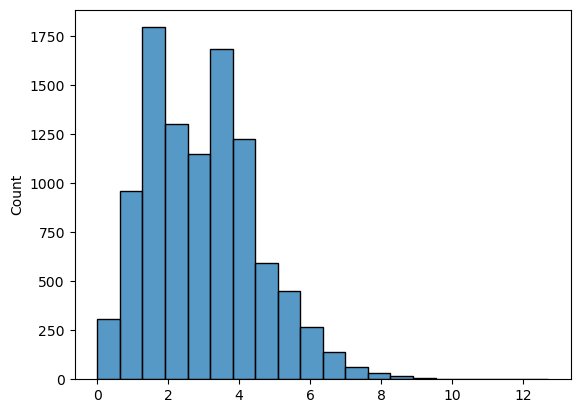

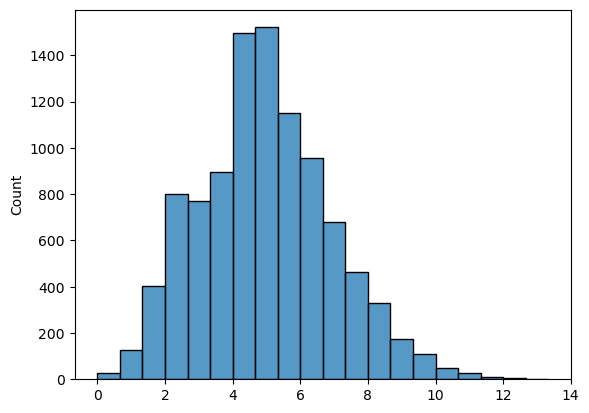

In [5]:
###--------------------------------------------BOOTSTRAPPING
src, tgt = bootstrap_genes(np.shape(df)[0], 10000, symbols_gtex.rename('genes'), db)

/tmp/ipykernel_3614259/2160060125.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  summary_LR['source+target'].replace({


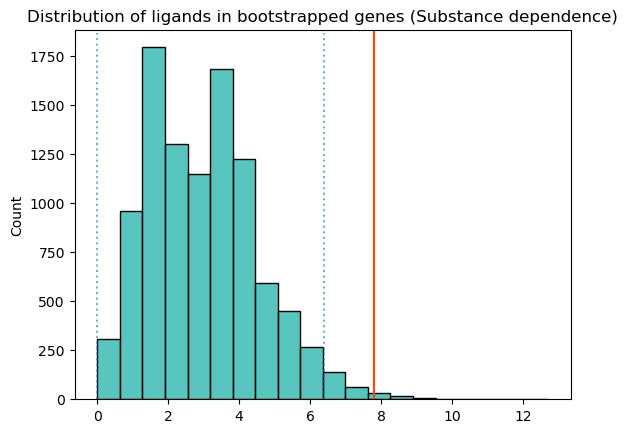

<function matplotlib.pyplot.show(close=None, block=None)>

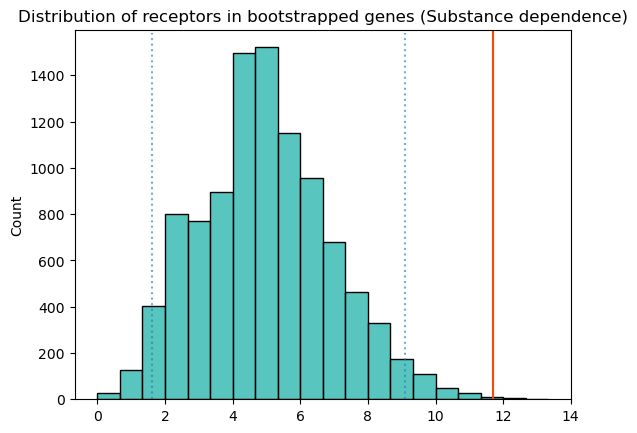

In [6]:
###--------------------------------------------LRs IN RISK GENES

#Calculate LR representation in risk genes
all_source, pctsrc, all_targets, pcttgt, summary_LR = find_hits(df,db)

g = sns.histplot(data = src, bins = 20, color = 'lightseagreen')
quant_5, quant_95 = np.quantile(src, 0.025), np.quantile(src, 0.975)
# [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.99], [quant_95, 0.6, 0.99]]
for i in quants:
    g.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
g.axvline(pctsrc, color = 'orangered')
plt.title('Distribution of ligands in bootstrapped genes (Substance dependence)')
plt.savefig('/dcs04/lieber/marmaypag/spatialNac_LIBD4125/spatial_NAc/plots/22_gene_risk_LR_analysis/03-LR_occurence_bootstrapped/bootstrapped_distribution_ligands_Substance_dependence.pdf', dpi = 300)
plt.show()

g = sns.histplot(data = tgt, bins = 20, color = 'lightseagreen')
quant_5, quant_95 = np.quantile(tgt, 0.025), np.quantile(tgt, 0.975)
# [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.99], [quant_95, 0.6, 0.99]]
for i in quants:
    g.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
g.axvline(pcttgt, color = 'orangered')
plt.title('Distribution of receptors in bootstrapped genes (Substance dependence)')
plt.savefig('/dcs04/lieber/marmaypag/spatialNac_LIBD4125/spatial_NAc/plots/22_gene_risk_LR_analysis/03-LR_occurence_bootstrapped/bootstrapped_distribution_receptors_Substance_dependence.pdf', dpi = 300)
plt.show